# SIR modelling as in: Data-driven approaches for predicting spread of infectious diseases through DINNs: Disease Informed Neural Networks

Notes for self:
SIR stands for 
- Susceptible
- Infective
- Removed (recovered)

S -> I -> R
The transfer rate from S->I is beta. Called transmission rate.
The transfer rate from I->R is alpha. Called recovery rate.

The system of ODE with the 3 variables is as follows. All variables are functions of time t:
dS/dt = -beta * S * I
dI/dt = beta * S * I - alpha * I
dR/dt = alpha I

Assumed that no one has recovered at the onset: 
R(0) = 0
Initial number of Infected is I(0) = I_0

## How DINN's are trained
1. The ODE's are solved with known initial conditions and true parameters (I think they mean alpha, beta etc.).
    This step results in a data series of S, I, R for each t. They use 50-100 points.
    They restrict the parameters around the true values. Not stated by how much.
2. For this set of data points we train using loss from
    - Data point loss
    - ODE loss

Note: I am a unsure how they obtain the parameters alpha beta from the network. They train the network to take in a time t and
output a S, I, R. How does this result in an alpha/beta etc.


In [5]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST
from timeit import default_timer as tdt
import torch.nn.init as init

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'
    
has_been_run = True

In [6]:
# Time setup
n_days = 1000
t_num = np.arange(0, n_days+1, 1)
t_mean = t_num.mean()
t_std = t_num.std()
print(f'Time domain: {t_num[0]} -> {t_num[-1]}')
print(f't_mean: {t_mean}')
print(f't_std:  {t_std}')

## Disease setup
alpha_SIR = 0.005
beta_SIR = 0.025

# Initial conditions
N = 10000.0    # Population size
I0 = 100.0/N      # Initial number of infected
R0 = 0.0/N      # Initial number of recovered
S0 = 1 - I0 - R0    # Initial number of susceptible

Time domain: 0 -> 1000
t_mean: 500.0
t_std:  288.9636655359978


In [7]:
# Normalize time for the network
def normalize_time(t_num):
    return (t_num - t_num.mean()) / t_num.std()
def unnormalize_time(t_norm, t_mean, t_std):
    return t_norm * t_std + t_mean
    
t_norm = normalize_time(t_num)
print(t_norm)
back_normalize = unnormalize_time(t_norm, t_num.mean(), t_num.std())
print(back_normalize)

[-1.73032135 -1.72686071 -1.72340007 ...  1.72340007  1.72686071
  1.73032135]
[   0.    1.    2. ...  998.  999. 1000.]


# Solving the system numerically 

In [8]:
# Solve numerically
def SIR_model_num(t, y, beta_SIR, alpha_SIR):
    S, I, R = y
    dSdt = -beta_SIR * S * I
    dIdt = beta_SIR * S * I - alpha_SIR * I
    dRdt = alpha_SIR * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0, I0, R0]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = sol.y[0]
I_data = sol.y[1]
R_data = sol.y[2]
print(sol.message)

The solver successfully reached the end of the integration interval.


Text(0.5, 1.0, 'Numerical Solution to SIR model')

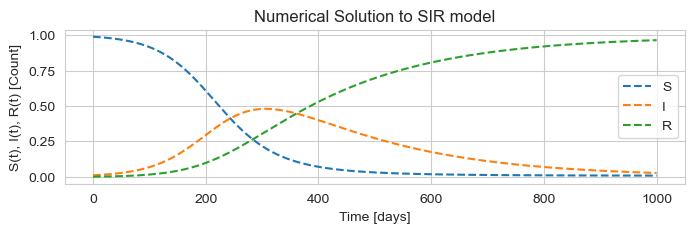

In [9]:
# Plot numerical solution
fig, ax = plt.subplots(1, 1, figsize=(8,2))
ax.plot(t_num, S_data, linestyle='--', label='S')
ax.plot(t_num, I_data, linestyle='--', label='I')
ax.plot(t_num, R_data, linestyle='--', label='R')

ax.set_xlabel('Time [days]')
ax.set_ylabel('S(t), I(t), R(t) [Count]')
ax.legend()
ax.set_title('Numerical Solution to SIR model')

# Training a neural network to solve the ODE system
In the following I will setup a network for solving the system of ODE's (SIR model).
I will assume we know beta and alpha here which is of course cheating. The idea is to figure out what 
network size we need in order to capture the dynamics.
## Description
### Loss functions
Two loss functions will be implemented at first
1. The ODE loss
2. The initial condition loss
Later loss based on data points will be implemented
### Network structure
The input for the network will be time t.
The output of the network will be U. 
where
S = U[0]
I = U[1]
R = U[2]

In [10]:
# ================== Loss functions ==================
# Defining loss function for reasons unknown
torch_MSE_loss = torch.nn.MSELoss()

# Loss for the ODE
def get_loss_ODE(net, t, t_real_to_t_normalize, beta_SIR, alpha_SIR):
    
    # Find network solution
    U = net(t)
    S = U[:,0].view(-1,1)
    I = U[:,1].view(-1,1)
    R = U[:,2].view(-1,1)
    
    # Calculate derivatives
    dSdt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0] * t_real_to_t_normalize
    dIdt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0] * t_real_to_t_normalize
    dRdt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0] * t_real_to_t_normalize
    
    # Calculate loss
    # Error1:
    rhs_S = -beta_SIR * S * I
    loss1 = torch_MSE_loss(dSdt, rhs_S)

    # Error2:
    rhs_I = beta_SIR * S * I - alpha_SIR * I
    loss2 = torch_MSE_loss(dIdt, rhs_I)
    
    # Error3:
    rhs_R = alpha_SIR * I
    loss3 = torch_MSE_loss(dRdt, rhs_R)
    
    # Summing the loss. Consider returning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3
    
    # Calculating residual
    res_S = rhs_S - dSdt
    res_I = rhs_I - dIdt
    res_R = rhs_R - dRdt
    
    return loss_total, torch.hstack((res_S, res_I, res_R))

# Loss for the initial condition
def get_loss_IC(net, t0, S0, I0, R0):
    # Find network solution
    U = net(t0.view(-1,1))   # reshape as there is only 1 time "t".

    S0_net = U[:,0]
    I0_net = U[:,1]
    R0_net = U[:,2]
    
    # Calculate loss
    loss1 = torch_MSE_loss(S0, S0_net)
    loss2 = torch_MSE_loss(I0, I0_net)
    loss3 = torch_MSE_loss(R0, R0_net)
    
    # Summing the loss. Consider retutning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3 
    
    return loss_total

def get_data_point_loss(net, t_data, S_data, I_data, R_data):
    
    t_adjust = normalize_time(t_data)
    # Find network solution
    U = net(t_adjust.view(-1,1))   # reshape as there is only 1 time "t".
    S_net = U[:,0]
    I_net = U[:,1]
    R_net = U[:,2]
    
    # Calculate loss
    loss1 = torch_MSE_loss(S_net, S_data)
    loss2 = torch_MSE_loss(I_net, I_data)
    loss3 = torch_MSE_loss(R_net, R_data)
    
    loss_total = loss1 + loss2 + loss3
    
    return loss_total
    
def get_loss_for_not_correct_number_of_people(net, t):
    # Find network solution
    U = net(t)
    S = U[:,0]
    I = U[:,1]
    R = U[:,2]
    
    # We should have always 1.0 total number of people (as fraction)
    total_number_of_people = S + I + R
    correct_total_number_of_people = torch.ones_like(total_number_of_people)
    
    # Loss is how much this is not 1.0
    loss_people_count = torch_MSE_loss(total_number_of_people, correct_total_number_of_people)
    
    # Adding loss for negative number of people
    if S.min() < 0.0 or I.min() < 0.0 or R.min() < 0.0:
        added_loss = torch_MSE_loss(S.min(), torch.tensor(0.0, device=my_device)) + \
                     torch_MSE_loss(I.min(), torch.tensor(0.0, device=my_device)) + \
                     torch_MSE_loss(R.min(), torch.tensor(0.0, device=my_device))
    else: 
        added_loss = 0.0
    
    return loss_people_count + added_loss
      
    
def get_loss_gradient_of_ODE(net, t, alpha, beta_SIR):
    # See paper: How to Avoid Trivial Solutions in Physics-Informed Neural Networks
    # Idea is to minimize max gradient in loss w.r.t. time to ensure it doesnt default to a homogenous solution.
    
    # Find network solution
    U = net(t)
    S = U[:,0]
    I = U[:,1]
    R = U[:,2]
    
    # Calculate derivatives
    dSdt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0].squeeze()
    dIdt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0].squeeze()
    dRdt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0].squeeze()
    
    # Calculate loss
    # Error1:
    rhs_S = -beta_SIR * S * I
    loss1 = torch_MSE_loss(dSdt, rhs_S)
    # Error2:
    rhs_I = beta_SIR * S * I - alpha_SIR * I
    loss2 = torch_MSE_loss(dIdt, rhs_I)
    # Error3:
    rhs_R = alpha_SIR * I
    loss3 = torch_MSE_loss(dRdt, rhs_R)
    
    # Summing the loss. Consider returning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3
    
    dloss_dt = torch.autograd.grad(loss_total, t, grad_outputs=torch.ones_like(loss_total), create_graph=True)[0].squeeze()
    
    loss_max = dloss_dt.max()
    
    return loss_max, dloss_dt



In [19]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0])
        self.L2 = nn.Linear(HL[0], HL[1])
        self.L3 = nn.Linear(HL[1], HL[2])
        self.L4 = nn.Linear(HL[2], HL[3])
        self.L5 = nn.Linear(HL[3], HL[4])
        self.L6 = nn.Linear(HL[4], HL[5])
        self.L7 = nn.Linear(HL[5], HL[6])
        self.L8 = nn.Linear(HL[6], HL[7])
        self.output = nn.Linear(HL[-1], output_size)
        
        
        # Initialize weights and biases
        for layer in [self.L1, self.L2, self.L3, self.L4, self.L5, self.L6, self.L7, self.L8, self.output]:
            init.xavier_uniform_(layer.weight)
            init.zeros_(layer.bias)
        
        
        # Define activation function
        self.act_fn = nn.Tanh()
        
        # Dropout
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.dropout(x)
        x = self.act_fn(self.L2(x))
        x = self.dropout(x)
        x = self.act_fn(self.L3(x))
        x = self.dropout(x)
        x = self.act_fn(self.L4(x))
        x = self.dropout(x)
        x = self.act_fn(self.L5(x))
        x = self.dropout(x)
        x = self.act_fn(self.L6(x))
        x = self.dropout(x)
        x = self.act_fn(self.L7(x))
        x = self.dropout(x)
        x = self.act_fn(self.L8(x))

        # Output layer
        x = self.output(x)
        
        return x

    
# Define network
net = FFN(1, [20,20,20,20,20,20,20,20], 3).to(my_device)

# Print Network shape
print()
print(net.parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test the network
print(net(torch.tensor(1.0, device=my_device).view(-1,1)))


<bound method Module.parameters of FFN(
  (L1): Linear(in_features=1, out_features=20, bias=True)
  (L2): Linear(in_features=20, out_features=20, bias=True)
  (L3): Linear(in_features=20, out_features=20, bias=True)
  (L4): Linear(in_features=20, out_features=20, bias=True)
  (L5): Linear(in_features=20, out_features=20, bias=True)
  (L6): Linear(in_features=20, out_features=20, bias=True)
  (L7): Linear(in_features=20, out_features=20, bias=True)
  (L8): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=3, bias=True)
  (act_fn): Tanh()
  (dropout): Dropout(p=0.0, inplace=False)
)>
tensor([[0.2399, 0.3323, 0.1809]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [20]:
# ================== Testing the loss functions ==================
t_test = torch.linspace(0, 1000, 1001, device=my_device, requires_grad=True).view(-1,1)
t0 = torch.tensor([0.0], device=my_device)

# Converting initial conditions for torch formatting
S0 = torch.tensor([S0], device=my_device)
I0 = torch.tensor([I0], device=my_device)
R0 = torch.tensor([R0], device=my_device)
print(f'Initial Conditions: S0: {S0}, I0: {I0}, R0: {R0}')

# Testing ODE loss
loss_ODE = get_loss_ODE(net, normalize_time(t_test), t_std, beta_SIR, alpha_SIR)
print(loss_ODE)



# Move data points to device 
if has_been_run:
    t_data = torch.tensor(t_num, device=my_device, dtype=torch.float32)
    S_data = torch.tensor(S_data, device=my_device, dtype=torch.float32)
    I_data = torch.tensor(I_data, device=my_device, dtype=torch.float32)
    R_data = torch.tensor(R_data, device=my_device, dtype=torch.float32)
has_been_run = False

# Testing IC loss
loss_IC = get_loss_IC(net, normalize_time(t_data)[0], S0, I0, R0)
print(loss_IC)

# Testing data loss
loss_data = get_data_point_loss(net, t_data, S_data, I_data, R_data)
print(loss_data)

# Testing 
loss_gradient_of_ode_loss, _ = get_loss_gradient_of_ODE(net, t_test, alpha_SIR, beta_SIR)
print(loss_gradient_of_ode_loss)

Initial Conditions: S0: tensor([0.9900], device='cuda:0'), I0: tensor([0.0100], device='cuda:0'), R0: tensor([0.], device='cuda:0')
(tensor(11209.9805, device='cuda:0', grad_fn=<AddBackward0>), tensor([[-13.8538,  -6.4322,   5.4284],
        [-13.9360,  -6.5338,   5.3924],
        [-14.0184,  -6.6359,   5.3560],
        ...,
        [-14.0184,  -6.6398,   5.3599],
        [-13.9360,  -6.5377,   5.3963],
        [-13.8538,  -6.4361,   5.4323]], device='cuda:0',
       grad_fn=<CatBackward0>))
tensor(1.8677, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8971, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6046e-07, device='cuda:0', grad_fn=<MaxBackward1>)


### Training the network on the losses

In [55]:
# Loss saving
loss_saved, loss_ODE_saved, loss_IC_saved, loss_data_saved, loss_people_count_saved = [], [], [], [], []
t_samples_saved = []
adapt_ode_loss_saved, adapt_IC_loss_saved, adapt_people_count_loss_saved = [], [], []
epochs_saved = [0]

# SoftAdapt setup
softadapt_obj  = LossWeightedSoftAdapt(beta=0.1)
epochs_to_make_change = 5
adapt_weights = torch.tensor([0.25, 0.25, 0.25])    # Initial weighting of objects.

# Setup optimizer
learning_rate = 3e-4
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Setup training scheduler as in the DINN paper
#base_lr = 1e-5
#max_lr = 1e-3   # Set your maximum learning rate
#gamma_lr = 0.85
#step_size_up = 1000  # Set the number of iterations for the learning rate to go from base_lr to max_lr
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
#                                        base_lr=base_lr, 
#                                        max_lr=max_lr, 
#                                        step_size_up=step_size_up, 
#                                        mode='exp_range',
#                                        cycle_momentum=False)

In [64]:
# Training setup
num_epochs = 1000
save_every_epochs = 100
points_per_epoch = 1000
loss_data = torch.tensor(0.0)
loss_max_grad = 0
max_R3_iter = 1

loss1, loss2, loss3, loss4, loss5 = [], [], [], [], []
net = net.to(my_device)
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Sample t using the R3 resampling strategy
    #t_samples_final = torch.tensor([], device=my_device)
    
    #for i in range(max_R3_iter):
    #    t_samples = 1000 * torch.rand(points_per_epoch, device=my_device, requires_grad=True).view(-1,1)
    #    new_ts = torch.cat((t_samples_final, t_samples))
    #    _, residual_ODE = get_loss_ODE(net, new_ts, alpha, beta)
    #    residual_sum = residual_ODE.sum(axis=0).abs().view(-1,1)
    #    threshold = residual_sum.mean()
    #    sorted_samples = new_ts[residual_sum > threshold].view(-1,1)
    #    t_samples_final = torch.cat((t_samples_final, sorted_samples, torch.linspace(0,100,100, device=my_device).view(-1,1)))
    
    #t_samples = t_samples_final
    
    t_samples = torch.linspace(0, 1000, points_per_epoch, device=my_device, requires_grad=True).view(-1,1)
    
    # Normalize time
    t_samples_norm = normalize_time(t_samples)
    
    #t_samples1 = torch.linspace(0, 1000, points_per_epoch, device=my_device, requires_grad=True).view(-1,1)
    #t_samples2 = 1000 * torch.rand(points_per_epoch, device=my_device, requires_grad=True).view(-1,1)
    #t_samples = torch.cat((t_samples1, t_samples2))

    # Calculate loss
    loss_ODE, residual_ODE = get_loss_ODE(net, t_samples_norm, 1/t_std, 1000*beta_SIR, alpha_SIR)
    loss_IC = get_loss_IC(net, t_samples_norm[0], S0, I0, R0)
    loss_data = get_data_point_loss(net, normalize_time(t_data), S_data, I_data, R_data)
    loss_people_count = get_loss_for_not_correct_number_of_people(net, t_samples_norm)
    #loss_max_grad, dloss_odedt = get_loss_gradient_of_ODE(net, t_samples, beta_SIR, alpha_SIR)

    loss1.append( loss_ODE )
    loss2.append( loss_IC )
    loss3.append( loss_data )
    loss4.append( loss_people_count )
    #loss5.append( loss_max_grad )

    # SoftAdapt using their package since lazy
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            torch.tensor(loss3), 
                                                            torch.tensor(loss4),
                                                            #torch.tensor(loss5),
                                                            verbose=False)
        loss1, loss2, loss3, loss4, loss5 = [], [], [], [], []
    
    loss = adapt_weights[0] * loss_ODE +    \
           adapt_weights[1] * loss_IC + \
           adapt_weights[2] * loss_people_count
           #adapt_weights[2] * loss_data

           #adapt_weights[3] * loss_people_count
            #+ \
           #0.0*adapt_weights[4] * loss_max_grad
    #loss = loss_data
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epoch {epoch+1:5}, Loss: {loss.item():8.8f}, ode_loss: {loss_ODE:8.8f}, ic_loss: {loss_IC:8.8f}"
              f", data_loss {loss_data:7.7f}, loss_count: {loss_people_count:7.7f}"
              f"\n             loss_grad: {loss_max_grad:7.7f}"
              f"\n             aw[0]: {adapt_weights[0]:3.6f}, aw[1]: {adapt_weights[1]:3.6f},aw[2]: {adapt_weights[2]:3.6f}"\
              )#f", aw[3]: {adapt_weights[3]:3.6f}")
    
    if (epoch+1) % 20 == 0:
        epochs_saved.append(epoch+1)
        loss_saved.append(loss.item())
        loss_ODE_saved.append(loss_ODE.detach().to('cpu'))
        loss_IC_saved.append(loss_IC.detach().to('cpu'))
        loss_data_saved.append(loss_data.detach().to('cpu'))
        loss_people_count_saved.append(loss_people_count.detach().to('cpu'))
        adapt_ode_loss_saved.append( adapt_weights[0]*loss_ODE.detach().to('cpu') )
        adapt_IC_loss_saved.append( adapt_weights[1]*loss_IC.detach().to('cpu') )
        #adapt_people_count_loss_saved.append( adapt_weights[2]*loss_IC.detach().to('cpu')  )
    
    # Save irregularlyu
    if (epoch+1) % 50 == 0 or epoch == 0:
        t_samples_saved.append( t_samples.detach().to('cpu') )


Epoch     1, Loss: 0.00006715, ode_loss: 0.04249455, ic_loss: 0.00009861, data_loss 0.2512339, loss_count: 0.0000003
             loss_grad: 0.0000000
             aw[0]: 0.001573, aw[1]: 0.000392,aw[2]: 0.998034
Epoch   100, Loss:      nan, ode_loss:      nan, ic_loss:      nan, data_loss     nan, loss_count:     nan
             loss_grad: 0.0000000
             aw[0]: nan, aw[1]: nan,aw[2]: nan
Epoch   200, Loss:      nan, ode_loss:      nan, ic_loss:      nan, data_loss     nan, loss_count:     nan
             loss_grad: 0.0000000
             aw[0]: nan, aw[1]: nan,aw[2]: nan
Epoch   300, Loss:      nan, ode_loss:      nan, ic_loss:      nan, data_loss     nan, loss_count:     nan
             loss_grad: 0.0000000
             aw[0]: nan, aw[1]: nan,aw[2]: nan
Epoch   400, Loss:      nan, ode_loss:      nan, ic_loss:      nan, data_loss     nan, loss_count:     nan
             loss_grad: 0.0000000
             aw[0]: nan, aw[1]: nan,aw[2]: nan
Epoch   500, Loss:      nan, ode_lo

In [ ]:
print(residual_ODE)

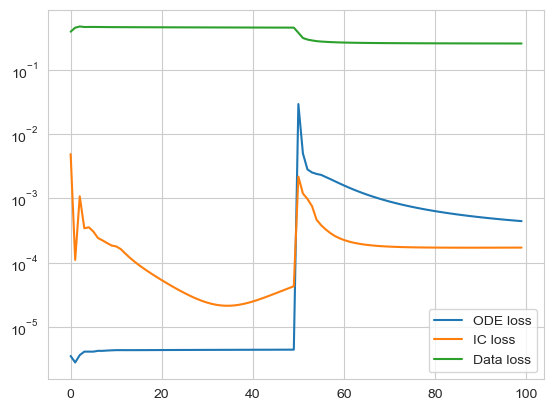

In [60]:
fig, ax = plt.subplots(1,1)
#ax.plot(loss_saved, label='loss')
ax.plot(loss_ODE_saved, label='ODE loss')
ax.plot(loss_IC_saved, label='IC loss')
ax.plot(loss_data_saved, label='Data loss')
#ax.plot(loss_people_count_saved, label='Count loss')
ax.legend()
ax.set_yscale('log')

In [45]:
t_plotting 
print(normalize_time(t_plotting))
print(unnormalize_time(normalize_time(t_plotting), t_mean, t_std))

tensor([[-1.7295],
        [-1.7260],
        [-1.7225],
        ...,
        [ 1.7225],
        [ 1.7260],
        [ 1.7295]])
tensor([[2.4985e-01],
        [1.2494e+00],
        [2.2488e+00],
        ...,
        [9.9775e+02],
        [9.9875e+02],
        [9.9975e+02]])


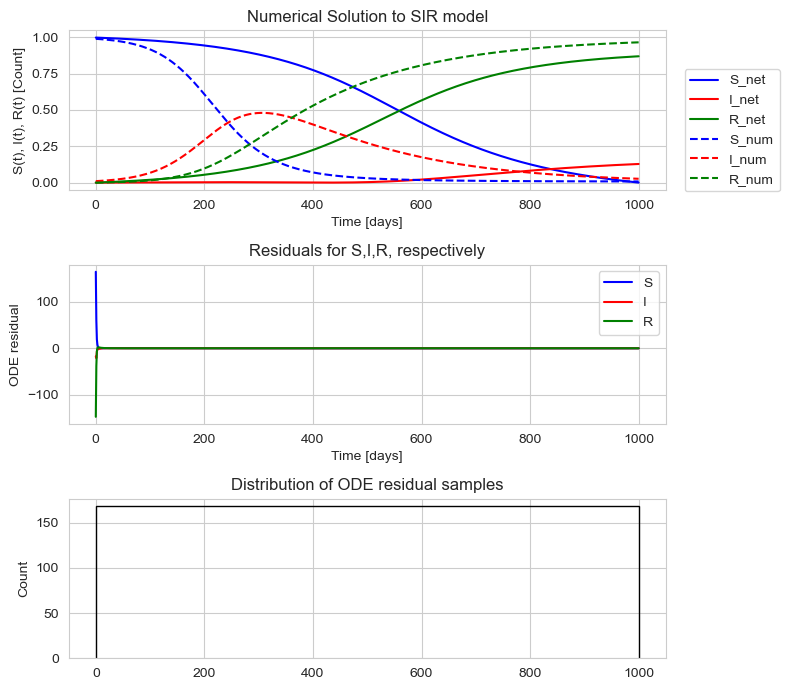

In [62]:
net_cpu = net.to('cpu')
net_cpu.eval()

t_plotting = t_data.clone().detach().to('cpu').float().view(-1,1).requires_grad_()
t_plotting = normalize_time(t_plotting)
U = net_cpu(t_plotting)
S_net = U[:,0]
I_net = U[:,1]
R_net = U[:,2]

# For checking loss functions
loss_max_grad, dloss_odedt = get_loss_gradient_of_ODE(net_cpu, t_plotting, beta_SIR, alpha_SIR)
# Calculate residual for each t
#loss_ode, residual_ODE = get_loss_ODE(net_cpu, t_plotting, alpha_SIR, beta_SIR)
t_plotting = unnormalize_time(t_plotting, t_mean, t_std)#.detach()
loss_ode, residual_ODE = get_loss_ODE(net_cpu, t_plotting, t_std, beta_SIR, alpha_SIR)
t_plotting = t_plotting.detach()

# Plot numerical solution
fig, ax = plt.subplots(3, 1, figsize=(8,7))
ax[0].plot(t_plotting, S_net.clone().detach().numpy(), linestyle='-', label='S_net', color='blue')
ax[0].plot(t_plotting, I_net.clone().detach().numpy(), linestyle='-', label='I_net', color='red')
ax[0].plot(t_plotting, R_net.clone().detach().numpy(), linestyle='-', label='R_net', color='green')
ax[0].plot(t_plotting, S_data.clone().to('cpu'), linestyle='--', label='S_num', color='blue')
ax[0].plot(t_plotting, I_data.clone().to('cpu'), linestyle='--', label='I_num', color='red')
ax[0].plot(t_plotting, R_data.clone().to('cpu'), linestyle='--', label='R_num', color='green')

ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('S(t), I(t), R(t) [Count]')
ax[0].legend(bbox_to_anchor=(1.02,0.8)) 
ax[0].set_title('Numerical Solution to SIR model')

ax[1].plot(t_plotting, residual_ODE[:,0].clone().detach(), color='blue', label='S')
ax[1].plot(t_plotting, residual_ODE[:,1].clone().detach(), color='red', label='I')
ax[1].plot(t_plotting, residual_ODE[:,2].clone().detach(), color='green', label='R')
ax[1].set_title('Residuals for S,I,R, respectively')
ax[1].legend()
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('ODE residual')

_ = ax[2].hist(torch.cat(t_samples_saved).to('cpu').detach().numpy(), histtype='step', color='k', bins=250)
ax[2].set_ylabel('Count')
ax[2].set_title('Distribution of ODE residual samples')
plt.tight_layout()

In [ ]:
print(((residual_ODE**2)).mean(axis=1).sum())
print(loss_ode)

In [ ]:
# check stuff using numpy and gradient
S_net_np = S_net.detach().numpy()
I_net_np = I_net.detach().numpy()
R_net_np = R_net.detach().numpy()

# Getting the numerical derivative
dSdt = np.gradient(S_net_np)
dIdt = np.gradient(I_net_np)
dRdt = np.gradient(R_net_np)

rhs_S = -beta_SIR * S_net_np * I_net_np
rhs_I = beta_SIR * S_net_np * I_net_np - alpha_SIR * I_net_np
rhs_R = alpha_SIR * I_net_np

# Getting the residual from the thing
res_nn_S = residual_ODE[0][0:1001].to('cpu').detach()
res_nn_I = residual_ODE[1][0:1001].to('cpu').detach()
res_nn_R = residual_ODE[2][0:1001].to('cpu').detach()

In [ ]:
# Plotting rhs and lhs of ODE's over time.
fig, ax = plt.subplots(1,1)
ax.plot(dSdt, color='blue', linestyle='-', label='dSdt')
ax.plot(rhs_S, color='blue', linestyle='--', label='rhs_S')
ax.plot(dIdt, color='red', linestyle='-', label='dSdt')
ax.plot(rhs_I, color='red', linestyle='--', label='rhs_S')
ax.plot(dRdt, color='green', linestyle='-', label='dSdt')
ax.plot(rhs_R, color='green', linestyle='--', label='rhs_S')
#ax.set_ylim(-0.01, 0.01)
ax.legend()
#ax.set_xlim(0,100)

In [ ]:
# Plotting population count over time. Ensure this is always close to 1.0
fig, ax = plt.subplots()
ax.plot(S_net_np + I_net_np + R_net_np)

In [ ]:
# Numerical residual vs autograd residual
res_num_S = rhs_S - dSdt
res_num_I = rhs_I - dIdt
res_num_R = rhs_R - dRdt

fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(res_num_S, color='red', label='Numerical')
ax[0].plot(res_nn_S, color='blue', linestyle='-', label='nn')
ax[1].plot(res_num_I, color='red', label='Numerical')
ax[1].plot(res_nn_I, color='blue', linestyle='-', label='nn')
ax[2].plot(res_num_R, color='red', label='Numerical')
ax[2].plot(res_nn_R, color='blue', linestyle='-', label='nn')
for i in range(3): 
    ax[i].legend()
    ax[i].set_title(['S', 'I', 'R'][i])
fig.suptitle('Residuals: Numerical and from NN. Check Axes. Should be very close')
plt.tight_layout()

In [ ]:
res_ODE = torch.vstack(residual_ODE)
res_ODE_sum = res_ODE.sum(axis=0).to('cpu').detach()

plt.plot(res_ODE_sum)

# Compute the threshold
tau_i = res_ODE_sum.mean()
print(tau_i)


In [ ]:
x = torch.tensor([]).view(-1,1)
y = torch.tensor([1,2,3]).view(-1,1)
print(x)
print(y)
print(torch.cat((x,y)))
print(torch.cat((x,y,y)))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(t_samples_final.to('cpu').clone().detach(), np.zeros_like(t_samples_final.to('cpu').detach()), marker='|')

In [ ]:
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt
import torch
# We redefine the loss components above for the sake of completeness.
loss_component_1 = torch.tensor([1, 2, 3, 4, 5])
loss_component_2 = torch.tensor([150, 100, 50, 10, 0.1])
loss_component_3 = torch.tensor([1500, 1000, 500, 100, 1])

# Here we define the different SoftAdapt objects
softadapt_object  = SoftAdapt(beta=0.1)
normalized_softadapt_object  = NormalizedSoftAdapt(beta=0.1)
loss_weighted_softadapt_object  = LossWeightedSoftAdapt(beta=0.1)


print(softadapt_object.get_component_weights(loss_component_1, loss_component_2, loss_component_3))
print(loss_weighted_softadapt_object.get_component_weights(loss_component_1, loss_component_2, loss_component_3))
